### preprocess & manipulation, pre-analysis
 - lead, ozone, pm2.5

### imports

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import requests as rq
from urllib.request import urlopen
import json
import os
import random
import math
import pathlib
import plotly.express as px
import matplotlib.collections as collections
%matplotlib inline

In [2]:
# pandas formatting 
pd.set_option("display.max_rows", 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### functions

In [3]:
# functions

def FIPS_function(row):
    state = str(row['State Code']).zfill(2)
    county = str(row['County Code']).zfill(3)
    return str(state + county)
# convert to NO2 ug/m^3 for reference
def no2_mass_by_vol(ppb):
    ugm3 = 1.88*ppb
    return ugm3

def set_daily_cases_deaths(df):
    df['daily_new_cases'] = df['JHU_ConfirmedCases.data'].diff()
    df['daily_new_deaths'] = df['JHU_ConfirmedDeaths.data'].diff()
    return df

# plotting one day's avg 
def show_day_mean(df, date):
    fig = px.choropleth(df[df['Date Local']==date], geojson=counties, locations='fips', color='Arithmetic Mean',
                               color_continuous_scale="Plasma",
                               range_color=(0, 70), #max value for daily avg is ~60ppb
                               scope="usa",
                               labels={'Arithmetic Mean':'Arithmetic Mean (ppb)'}
                              )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":1,'autoexpand':True })
    fig.update_layout(
        autosize=False,
        width=1200,
        height=900,
    )
    return fig

# plotting one day's max value
def show_day_max(df, date):
    fig = px.choropleth(df[df['Date Local']==date], geojson=counties, locations='fips', color='1st Max Value',
                               color_continuous_scale="Plasma",
                               range_color=(0, 70), #max value for daily avg is ~60ppb
                               scope="usa",
                               labels={'1st Max Value':'1st Max Value (ppb)'}
                              )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":1,'autoexpand':True })
    fig.update_layout(
        autosize=False,
        width=1200,
        height=900,
    )
    return fig  

def show_sites(df):
    fig = px.choropleth(df, geojson=counties, locations='fips', color='Parameter Code',
                               color_continuous_scale="Plasma",
                               range_color=(0, 1), #max value for daily avg is ~60ppb
                               scope="usa",
                               labels={'1st Max Value':'1st Max Value (ppb)'}
                              )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":1,'autoexpand':True })
    fig.update_layout(
        autosize=False,
        width=1200,
        height=900,
    )
    return fig

def get_counties_df(file_name='./data/covid/config/counties.json'):
    with open(file_name) as file:
                county_data = json.load(file)
    
    df = pd.DataFrame.from_dict(county_data)
    
    data = [df[col] for col in df.columns]    
    
    # pivot
    return pd.DataFrame(data,columns=df.index, index=df.columns)

def get_fips_from_county_lookup():
    counties = get_counties_df() 
    counties = counties.dropna(subset=['fips'])
    counties.fips = counties.fips.apply(lambda f: eval(str(f)).get('id'))
    counties_index = {k: v for k, v in zip(counties.index, counties.fips)}
    def get_fips_from_county(county):
        return counties_index[county]
    return get_fips_from_county

def avg_county_pollution(df, column_to_avg = "Arithmetic Mean", date_column=None):    
    if date_column == None:
        date_column = 'Date Local'
    # All days 
    # days = list(df[date_column].unique())
    # all_fips = list(df['fips'].unique())
    avg_by_day = df.groupby(['Date Local','fips']).agg({'Arithmetic Mean': 'mean','1st Max Value':'max','AQI':'max'})
    return avg_by_day

def cols_missing(df):
    total = 0
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        total += missing_vals
        pct = df[col].isna().mean() * 100
        if missing_vals != 0:
            print(f"{col} = {df[col].isnull().sum()}",'--','{} = {}%'.format(col, round(pct, 2)))
    if total == 0:
        print("no missing values left")
        
def print_outliers(df,col):
    print(col)
    #print(df[col].describe())
    print('Min: ',df[col].min())
    print('1st quartile: ',df[col].quantile(0.25))
    print('3rd quartile: ',df[col].quantile(0.75))
    print('Max: ',df[col].max())
    #print(sns.boxplot(x=df[col]))

In [4]:
##
def daily_avg_county_pollution(df, column_to_avg = "Arithmetic Mean", date_column=None):    
    if date_column == None:
        date_column = 'Date Local'
        avg_by_day = df.groupby([date_column,'fips']).agg({'Arithmetic Mean': 'mean','1st Max Value':'max','AQI':'max'})
    else:
        avg_by_day = df.groupby([date_column,'Date Local','fips']).agg({'Arithmetic Mean': 'mean','1st Max Value':'max','AQI':'max'})
        
        
    return avg_by_day

def daily_avg_county_pollution_lead(df, column_to_avg = "1st Max Value", date_column=None):    
    if date_column == None:
        date_column = 'Date Local'
        avg_by_day = df.groupby([date_column,'fips']).agg({'Arithmetic Mean': 'mean','1st Max Value':'max','AQI':'max'})
    else:
        avg_by_day = df.groupby([date_column,'Date Local','fips']).agg({'Arithmetic Mean': 'mean','1st Max Value':'max','AQI':'max'})
        
        
    return avg_by_day

def check_level(df, averages, delta=0):
    targets = {}
    for fipc in list(averages.keys()):
        df[df['fips']==fipc]
        peak_df = df[(df['fips']==fipc) & (df['Arithmetic Mean'] >= (averages[fipc]['mean_ppb'] + delta))]
        targets[fipc] = peak_df[['Date Local','Arithmetic Mean']].to_dict()
    return targets

### import data

In [5]:
#pm2.5 speciation
og_pm19 = pd.read_csv('data/daily_pm25_2019_FIPS.csv', dtype={'fips':'string'})
og_pm20 = pd.read_csv('data/daily_pm25_2020_FIPS.csv', dtype={'fips':'string'})
og_pm21 = pd.read_csv('data/daily_pm25_2021_FIPS.csv', dtype={'fips':'string'})

#ozone
og_ozone19 = pd.read_csv('data/daily_ozone_2019_FIPS.csv', dtype={'fips':'string'})
og_ozone20 = pd.read_csv('data/daily_ozone_2020_FIPS.csv', dtype={'fips':'string'})
og_ozone21 = pd.read_csv('data/daily_ozone_2021_FIPS.csv', dtype={'fips':'string'})

#lead
og_lead19 = pd.read_csv('data/daily_lead_2019_FIPS.csv', dtype={'fips':'string'})
og_lead20 = pd.read_csv('data/daily_lead_2020_FIPS.csv', dtype={'fips':'string'})
og_lead21 = pd.read_csv('data/daily_lead_2021_FIPS.csv', dtype={'fips':'string'})

####drop columns
cols_to_drop = ['Pollutant Standard','POC','Parameter Code','Parameter Name','Sample Duration'
               , 'Method Code','Method Name','City Name','Date of Last Change']

pm19 = og_pm19.drop(cols_to_drop, axis=1)
pm20 = og_pm20.drop(cols_to_drop, axis=1)
pm21 = og_pm21.drop(cols_to_drop, axis=1)

ozone19 = og_ozone19.drop(columns=cols_to_drop,axis=1)
ozone20 = og_ozone20.drop(columns=cols_to_drop,axis=1)
ozone21 = og_ozone21.drop(columns=cols_to_drop,axis=1)

lead19 = og_lead19.drop(columns=cols_to_drop,axis=1)
lead20 = og_lead20.drop(columns=cols_to_drop,axis=1)
lead21 = og_lead21.drop(columns=cols_to_drop,axis=1)

#datetime conversion
pm19['Date Local'] = pd.to_datetime(pm19['Date Local'], format="%Y/%m/%d")
pm20['Date Local'] = pd.to_datetime(pm20['Date Local'], format="%Y/%m/%d")
pm21['Date Local'] = pd.to_datetime(pm21['Date Local'], format="%Y/%m/%d")

ozone19['Date Local'] = pd.to_datetime(ozone19['Date Local'], format="%Y/%m/%d")
ozone20['Date Local'] = pd.to_datetime(ozone20['Date Local'], format="%Y/%m/%d")
ozone21['Date Local'] = pd.to_datetime(ozone21['Date Local'], format="%Y/%m/%d")

lead19['Date Local'] = pd.to_datetime(lead19['Date Local'], format="%Y/%m/%d")
lead20['Date Local'] = pd.to_datetime(lead20['Date Local'], format="%Y/%m/%d")
lead21['Date Local'] = pd.to_datetime(lead21['Date Local'], format="%Y/%m/%d")

### daily avg

In [6]:
#pm
daily_avg_pm19 = daily_avg_county_pollution(pm19)
daily_avg_pm20 = daily_avg_county_pollution(pm20)
daily_avg_pm21 = daily_avg_county_pollution(pm21)

#ozone
daily_avg_ozone19 = daily_avg_county_pollution(ozone19)
daily_avg_ozone20 = daily_avg_county_pollution(ozone20)
daily_avg_ozone21 = daily_avg_county_pollution(ozone21)

#lead
daily_avg_lead19 = daily_avg_county_pollution(lead19)
daily_avg_lead20 = daily_avg_county_pollution(lead20)
daily_avg_lead21 = daily_avg_county_pollution(lead21)

### county means

In [7]:
#pm
county_means_pm19 = daily_avg_pm19.reset_index().groupby(['fips']).mean().drop(['1st Max Value'],axis=1)
county_means_pm20 = daily_avg_pm20.reset_index().groupby(['fips']).mean().drop(['1st Max Value'],axis=1)
county_means_pm21 = daily_avg_pm21.reset_index().groupby(['fips']).mean().drop(['1st Max Value'],axis=1)

#ozone
county_means_ozone19 = daily_avg_ozone19.reset_index().groupby(['fips']).mean().drop(['1st Max Value'],axis=1)
county_means_ozone20 = daily_avg_ozone20.reset_index().groupby(['fips']).mean().drop(['1st Max Value'],axis=1)
county_means_ozone21 = daily_avg_ozone21.reset_index().groupby(['fips']).mean().drop(['1st Max Value'],axis=1)


#should do avgs for 1st max

#lead
county_means_lead19 = daily_avg_lead19.reset_index().groupby(['fips']).mean().drop(['AQI'],axis=1)
county_means_lead20 = daily_avg_lead20.reset_index().groupby(['fips']).mean().drop(['AQI'],axis=1)
county_means_lead21 = daily_avg_lead21.reset_index().groupby(['fips']).mean().drop(['AQI'],axis=1)

### convert to dictionary

In [86]:
# pm25
county_means_pm19.rename(columns={'Arithmetic Mean':'mean_ppb','AQI':'mean_AQI'},inplace=True)
county_means_pm20.rename(columns={'Arithmetic Mean':'mean_ppb','AQI':'mean_AQI'},inplace=True)
county_means_pm21.rename(columns={'Arithmetic Mean':'mean_ppb','AQI':'mean_AQI'},inplace=True)

county_benchmarks_pm19 = county_means_pm19.to_dict('index')
county_benchmarks_pm20 = county_means_pm20.to_dict('index')
county_benchmarks_pm21 = county_means_pm21.to_dict('index')


# ozone
county_means_ozone19.rename(columns={'Arithmetic Mean':'mean_ppb','AQI':'mean_AQI'},inplace=True)
county_means_ozone20.rename(columns={'Arithmetic Mean':'mean_ppb','AQI':'mean_AQI'},inplace=True)
county_means_ozone21.rename(columns={'Arithmetic Mean':'mean_ppb','AQI':'mean_AQI'},inplace=True)

county_benchmarks_ozone19 = county_means_ozone19.to_dict('index')
county_benchmarks_ozone20 = county_means_ozone20.to_dict('index')
county_benchmarks_ozone21 = county_means_ozone21.to_dict('index')


# lead
county_means_lead19.rename(columns={'Arithmetic Mean':'mean_ppb','1st Max Value':'mean_max'},inplace=True)
county_means_lead20.rename(columns={'Arithmetic Mean':'mean_ppb','1st Max Value':'mean_max'},inplace=True)
county_means_lead21.rename(columns={'Arithmetic Mean':'mean_ppb','1st Max Value':'mean_max'},inplace=True)

county_benchmarks_lead19 = county_means_lead19.to_dict('index')
county_benchmarks_lead20 = county_means_lead20.to_dict('index')
county_benchmarks_lead21 = county_means_lead21.to_dict('index')

In [87]:
##flats

#pm
flat_daily_avg_pm19 = daily_avg_pm19.reset_index()
flat_daily_avg_pm20 = daily_avg_pm20.reset_index()
flat_daily_avg_pm21 = daily_avg_pm21.reset_index()

#ozone
flat_daily_avg_ozone19 = daily_avg_ozone19.reset_index()
flat_daily_avg_ozone20 = daily_avg_ozone20.reset_index()
flat_daily_avg_ozone21 = daily_avg_ozone21.reset_index()

#lead
flat_daily_avg_lead19 = daily_avg_lead19.reset_index()
flat_daily_avg_lead20 = daily_avg_lead20.reset_index()
flat_daily_avg_lead21 = daily_avg_lead21.reset_index()

In [88]:
flat_daily_avg_pm20['Arithmetic Mean'].mean()

7.781185312956149

In [89]:
flat_daily_avg_ozone20['Arithmetic Mean'].mean()

0.03006179008579186

In [90]:
flat_daily_avg_lead20['Arithmetic Mean'].mean()

0.020707880643627982

### rounded up each mean to act as the delta

In [91]:
pm_delta = 7.8
ozone_delta = 0.031
lead_delta = 0.021

### cross ref keys

In [205]:
#pm19
to_cross_ref_pm19 = check_level(flat_daily_avg_pm19,county_benchmarks_pm19,delta=pm_delta)
to_cross_ref_pm20 = check_level(flat_daily_avg_pm20,county_benchmarks_pm20,delta=pm_delta)
to_cross_ref_pm21 = check_level(flat_daily_avg_pm21,county_benchmarks_pm21,delta=pm_delta)

pm19_cref_keys = list(to_cross_ref_pm19.keys())
pm20_cref_keys = list(to_cross_ref_pm20.keys())
pm21_cref_keys = list(to_cross_ref_pm21.keys())

#ozone
to_cross_ref_ozone19 = check_level(flat_daily_avg_ozone19,county_benchmarks_ozone19,delta=ozone_delta)
to_cross_ref_ozone20 = check_level(flat_daily_avg_ozone20,county_benchmarks_ozone20,delta=ozone_delta)
to_cross_ref_ozone21 = check_level(flat_daily_avg_ozone21,county_benchmarks_ozone21,delta=ozone_delta)

ozone19_cref_keys = list(to_cross_ref_ozone19.keys())
ozone20_cref_keys = list(to_cross_ref_ozone20.keys())
ozone21_cref_keys = list(to_cross_ref_ozone21.keys())


#lead 
to_cross_ref_lead19 = check_level(flat_daily_avg_lead19,county_benchmarks_lead19,delta=lead_delta)
to_cross_ref_lead20 = check_level(flat_daily_avg_lead20,county_benchmarks_lead20,delta=lead_delta)
to_cross_ref_lead21 = check_level(flat_daily_avg_lead21,county_benchmarks_lead21,delta=lead_delta)

lead19_cref_keys = list(to_cross_ref_lead19.keys())
lead20_cref_keys = list(to_cross_ref_lead20.keys())
lead21_cref_keys = list(to_cross_ref_lead21.keys())

# covid functions

In [206]:
def load_covid_by_fips(fipcode):
    df = pd.read_pickle(NOAH_WKDIR.joinpath("processed_data","county_merged_parts",get_county_from_fips(fipcode)+'.pkl'))   
    return df
clamped_covid = ['fips','JHU_ConfirmedCases.data','JHU_ConfirmedDeaths.data', 
                 'latestTotalPopulation','MaleAndFemale_AtLeast65_Population.data',
                 'Male_Total_Population.data','Female_Total_Population.data',
                 'MaleAndFemale_Under18_Population.data','BLS_EmployedPopulation.data',
                 'BLS_UnemployedPopulation.data','BLS_UnemploymentRate.data',
                 'BLS_LaborForcePopulation.data','AverageWindDirection.data',
                ]

def stringify_fips(row):
    ''' Convert the INTeger representation of fips to a string with leading zeros.
            intended to be used in a lamda function.
            
    Arguments:
    
    row - a single row of a dataframe. Intended to be used like "df4.apply(lambda row: stringify_fips(row), axis=1)"
    
    '''
    strFips = str(row['fips']).zfill(5)
    return strFips

def rolling_cases(df, window_size=7):
    df['1wkroll'] = df['daily_new_cases'].rolling(window=window_size).mean()
    df.reset_index(inplace=True)
    df.set_index("dates",inplace = True)
    return df

# cases / 100,000 people
def set_weighted_cases(df):
    wpop =  df['latestTotalPopulation'].max()/100000
    z = df.loc[:,'JHU_ConfirmedCases.data'] / wpop
    df['total_cases_per_100k'] = z.values    
    return df

#deaths per person infected
def set_death_per_cases(df):
    df.loc[:,'deaths_per_cases']= np.where((df.loc[:,'JHU_ConfirmedDeaths.data'] / df.loc[:,'JHU_ConfirmedCases.data'])>=0,
                                          (df.loc[:,'JHU_ConfirmedDeaths.data'] / df.loc[:,'JHU_ConfirmedCases.data']), 0)
    return df

In [207]:

def save_if_not(df, fip):
    # if *fip* not found in 'my_savedir' then save it correctly
    pass


def load_and_augment_fips(fips):
    tdf = load_covid_by_fips(fips)
    # pickle loads numbers as floats; converting fips to int
    tdf['fips'] = tdf.apply(lambda row: math.floor(row['fips']), axis=1)

    # Making fips a string to match on other datasets with leading zero
    df2= tdf.astype({"fips":"int"}).astype({'fips':'string'})
    
    # adding leading zero where needed
    df2['fips'] = df2.apply(lambda row: stringify_fips(row), axis=1)
    
    #need daily change in cases to get the rolling delta of new infections
    df2 = set_daily_cases_deaths(df2)
    df2 = rolling_cases(df2)
    df2.index = pd.to_datetime(df2.index, format="%Y/%m/%d")
    top_level_covid = ['fips','daily_new_cases','daily_new_deaths', "1wkroll",
                   'JHU_ConfirmedCases.data','JHU_ConfirmedDeaths.data', 
                   'latestTotalPopulation']
    
    
    df3 = df2[top_level_covid].copy()
    df3 = set_weighted_cases(df3)
    df3 = set_death_per_cases(df3)
    
    del df2
    del tdf
    
    
    
    return df3



### for single lodaded covid df
def load_and_augment_fips_2(tdf,fips):
    # pickle loads numbers as floats; converting fips to int
    tdf['fips'] = tdf.apply(lambda row: math.floor(row['fips']), axis=1)

    # Making fips a string to match on other datasets with leading zero
    df2= tdf.astype({"fips":"int"}).astype({'fips':'string'})
    
    # adding leading zero where needed
    df2['fips'] = df2.apply(lambda row: stringify_fips(row), axis=1)
    
    #need daily change in cases to get the rolling delta of new infections
    df2 = set_daily_cases_deaths(df2)
    df2 = rolling_cases(df2)
    df2.index = pd.to_datetime(df2.index, format="%Y/%m/%d")
    top_level_covid = ['fips','daily_new_cases','daily_new_deaths', "1wkroll",
                   'JHU_ConfirmedCases.data','JHU_ConfirmedDeaths.data', 
                   'latestTotalPopulation']
    
    
    df3 = df2[top_level_covid].copy()
    df3 = set_weighted_cases(df3)
    df3 = set_death_per_cases(df3)
    
    del df2
    del tdf
    
    return df3

In [208]:
# function to pull from url

def convert_fips_to_county_name(fips):
    return filename

def pull_covid_from_github(filename):
    df = pd.read_pickle(filename)
    return df

In [224]:
#### somethings up with pickel ####
denver_covid = pd.read_pickle('Denver_Colorado_UnitedStates.pkl')

## check with one county

In [355]:
### find a county that has data for all pollutants for intial / random

#incommon = set(pm20_cref_keys).intersection(ozone20_cref_keys, lead20_cref_keys)
incommon = np.intersect1d(pm20_cref_keys,ozone20_cref_keys, lead20_cref_keys)
random_fips = random.choice(incommon)
print(random_fips)

20173


In [217]:
get_county_name(pm20,'18089')

array(['Lake'], dtype=object)

In [301]:
###### specifiy fips code
### '18089' or lake county, indiana
### may be different when ran again

fips_target = '18089'

In [302]:
# Collect list of dates for the target county
c_dates_pm20 = list(to_cross_ref_pm20[fips_target]['Date Local'].values())
c_dates_ozone20 = list(to_cross_ref_ozone20[fips_target]['Date Local'].values())
c_dates_lead20 = list(to_cross_ref_lead20[fips_target]['Date Local'].values())

In [366]:
#import covid for fips above
lake_covid = pd.read_pickle('Lake_Indiana_UnitedStates.pkl')

#check peaks, but main analysis with lake

#mono = pd.read_pickle('Monona_Iowa_UnitedStates.pkl')
#mono_covid = load_and_augment_fips_2(mono,'06051')

#nevada = pd.read_pickle('Nevada_California_UnitedStates.pkl')
#nevada_covid = load_and_augment_fips_2(nevada,'06057')

#iron = pd.read_pickle('Iron_Missouri_UnitedStates.pkl')
#iron_covid = load_and_augment_fips_2(iron,'29093')

In [304]:
#datetime index conditions

pm20df = daily_avg_pm20.reset_index().set_index('Date Local')
#pm20df[['Arithmetic Mean']][pm20df['fips'] == target_fips].loc['2020-12-01':'2020-12-20'][0:3]

ozone20df = daily_avg_ozone20.reset_index().set_index('Date Local')
#ozone20df[['Arithmetic Mean']][ozone20df['fips'] == target_fips].loc['2020-12-01':'2020-12-20'][0:3]

lead20df = daily_avg_lead20.reset_index().set_index('Date Local')
#lead20df[['Arithmetic Mean']][lead20df['fips'] == target_fips].loc['2020-12-01':'2020-12-20'][0:3]

In [305]:
## leveraging datetime functionality
tdate = pd.Timestamp('2020-12-10')
#tdate = pd.Timestamp.date(t)
offset = pd.offsets.Week()

In [306]:
target_fips = fips_target

pm20_vals = pm20df[pm20df['fips'] == target_fips].loc[tdate - offset:tdate+offset]["Arithmetic Mean"]
ozone20_vals = ozone20df[ozone20df['fips'] == target_fips].loc[tdate - offset:tdate+offset]["Arithmetic Mean"]
lead20_vals = lead20df[lead20df['fips'] == target_fips].loc[tdate - offset:tdate+offset]["Arithmetic Mean"]

In [307]:
# getting a rolling average of the no2 concentrations

pm20_rolling_mean = pm20df.groupby("fips")[['Arithmetic Mean']].rolling(window=3).mean()
ozone20_rolling_mean = ozone20df.groupby("fips")[['Arithmetic Mean']].rolling(window=3).mean()
lead20_rolling_mean = lead20df.groupby("fips")[['Arithmetic Mean']].rolling(window=3).mean()


pm20_rolling_peak = pm20_rolling_mean.groupby("fips").idxmax()
ozone20_rolling_peak = ozone20_rolling_mean.groupby("fips").idxmax()
lead20_rolling_peak = lead20_rolling_mean.groupby("fips").idxmax()

pm20_raw_peak = pm20df.groupby("fips")[['Arithmetic Mean']].idxmax()
ozone20_raw_peak = ozone20df.groupby("fips")[['Arithmetic Mean']].idxmax()
lead20_raw_peak = lead20df.groupby("fips")[['Arithmetic Mean']].idxmax()


rolling_peaks_dict_pm20 = {}
rolling_peaks_dict_ozone20 = {}
rolling_peaks_dict_lead20 = {}


for artup in pm20_rolling_peak.values:
    tup = artup[0]
    rolling_peaks_dict_pm20[tup[0]] = tup[1]
    
for artup in ozone20_rolling_peak.values:
    tup = artup[0]
    rolling_peaks_dict_ozone20[tup[0]] = tup[1]
    
for artup in lead20_rolling_peak.values:
    tup = artup[0]
    rolling_peaks_dict_lead20[tup[0]] = tup[1]

    
raw_peaks_dict_pm20 = {}
raw_peaks_dict_ozone20 = {}
raw_peaks_dict_lead20 = {}

for tup in pm20_raw_peak.itertuples():
    raw_peaks_dict_pm20[tup[0]] = tup[1]
    
for tup in ozone20_raw_peak.itertuples():
    raw_peaks_dict_ozone20[tup[0]] = tup[1]
    
for tup in lead20_raw_peak.itertuples():
    raw_peaks_dict_lead20[tup[0]] = tup[1]

In [308]:
pm20_stdList = flat_daily_avg_pm20.groupby("fips")['Arithmetic Mean'].std()
#print('pm20:\n',pm20_stdList[:5])

ozone20_stdList = flat_daily_avg_ozone20.groupby("fips")['Arithmetic Mean'].std()
#print('\nozone20:\n',ozone20_stdList[:5])

lead20_stdList = flat_daily_avg_lead20.groupby("fips")['Arithmetic Mean'].std()
#print('\nlead20:\n',lead20_stdList[:5])

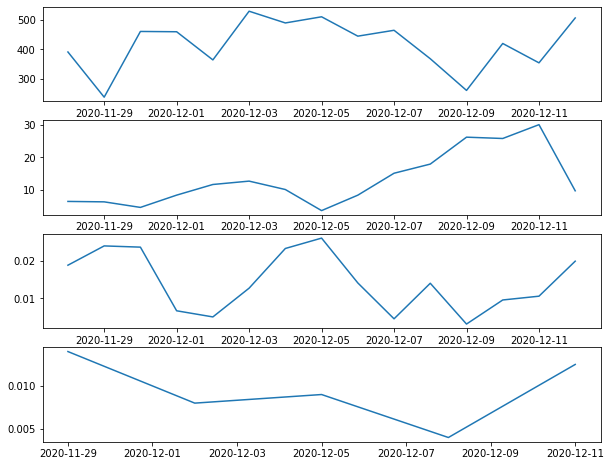

In [309]:
tfip = target_fips

#center_date = ex_dict[tfip]
center_date = pd.Timestamp('2020-12-05')

fig, axs = plt.subplots(4,1,figsize =(10,8) )
covdf2 = load_and_augment_fips_2(lake_covid,tfip)

cov_interval = covdf2.loc[center_date - offset:center_date+offset]
axs[0].plot(cov_interval['daily_new_cases'])

pm20_vals = pm20df[pm20df['fips'] == tfip].loc[center_date - offset:center_date+offset]["Arithmetic Mean"]
axs[1].plot(pm20_vals)

ozone20_vals = ozone20df[ozone20df['fips'] == tfip].loc[center_date - offset:center_date+offset]["Arithmetic Mean"]
axs[2].plot(ozone20_vals)

lead20_vals = lead20df[lead20df['fips'] == tfip].loc[center_date - offset:center_date+offset]["Arithmetic Mean"]
axs[3].plot(lead20_vals)

In [310]:
def dual_plot(tfip,covid_df,no2df,rolling_peaks_dict,titlee):
    elist = []
    center_date = rolling_peaks_dict[tfip]
    #covdf2 = load_and_augment_fips(tfip)
    covdf2 = load_and_augment_fips_2(covid_df,tfip) 
    
    fig, axs = plt.subplots(2,1,figsize =(11,8))
    no2_vals = no2df[no2df['fips'] == tfip].loc[center_date - offset:center_date+offset]["Arithmetic Mean"]
    cov_interval = covdf2.loc[center_date - offset:center_date+offset]    
    title_text = "{} daily cases".format(tfip)
    axs[0].set_title(title_text)
    axs[0].plot(cov_interval["daily_new_cases"],'b',label="daily cases")
    #axs[0].plot(cov_interval["daily_new_cases"].shift(-7,freq="D"),'r', label="shifted back 7 days")
    axs[0].legend()
    axs[1].plot(no2_vals)
    axs[1].set_title(titlee)
    # fig.update_layout(
    #         autosize=False,
    #         width=1300,
    #         height=1100,)
    # fig.savefig(cwd.joinpath("no2_images","county_peak_plots",f"{tfip}_comparison.jpg"))
    # plt.close()

In [311]:
print(tfip)

18089


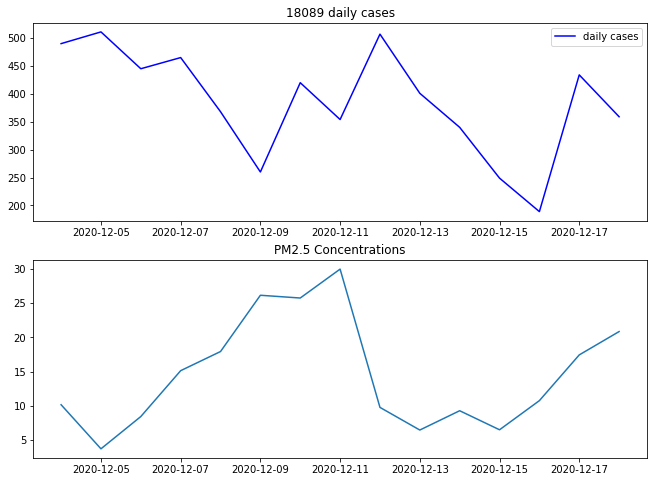

In [312]:
dual_plot(tfip, lake_covid, pm20df, rolling_peaks_dict_pm20,'PM2.5 Concentrations')

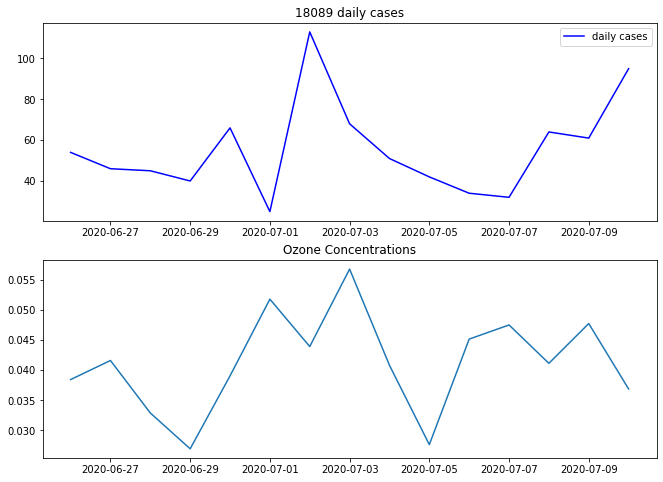

In [313]:
dual_plot(tfip, lake_covid, ozone20df, rolling_peaks_dict_ozone20,'Ozone Concentrations')

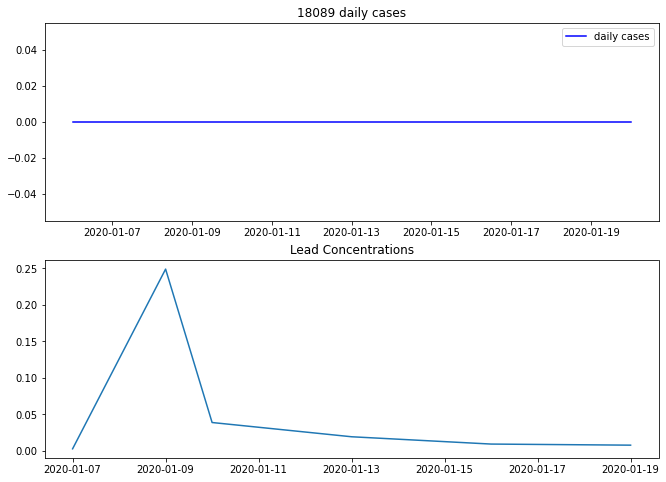

In [314]:
dual_plot(tfip, lake_covid, lead20df, rolling_peaks_dict_lead20,'Lead Concentrations')

Text(0.5, 1.0, 'Lead Concentrations')

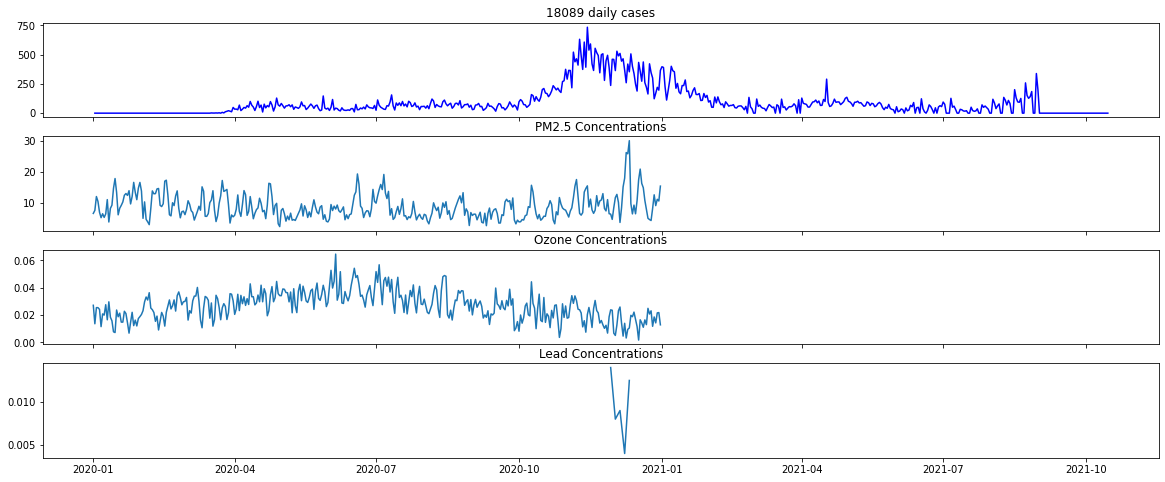

In [252]:
#covdf2 = load_and_augment_fips(tfip)
covdf2 = load_and_augment_fips_2(lake_covid,tfip) 
fig, axs = plt.subplots(4,1,figsize =(20,8), sharex=True)
pm20_vals = pm20df[pm20df['fips'] == tfip]["Arithmetic Mean"]
ozone20_vals = ozone20df[ozone20df['fips'] == tfip]["Arithmetic Mean"]

title_text = "{} daily cases".format(tfip)

axs[0].set_title(title_text)
axs[0].plot(covdf2["daily_new_cases"],'b',label="daily cases")

axs[1].plot(pm20_vals)
axs[1].set_title("PM2.5 Concentrations")

axs[2].plot(ozone20_vals)
axs[2].set_title("Ozone Concentrations")

axs[3].plot(lead20_vals)
axs[3].set_title("Lead Concentrations")

# fig.savefig(cwd.joinpath("no2_images","test",f"{tfip}_comparison.jpg"))
# plt.close()

## Correlations

#### raw correlations

In [315]:
tfip = tfip # jsut incase you want to change it for correlations
print(tfip)
target_key = pm20_cref_keys.index(tfip)

#cdf = load_and_augment_fips(pm20_cref_keys[target_key])
cdf = load_and_augment_fips_2(lake_covid,pm20_cref_keys[target_key])

# target pollution dataframe = tpdf
tpdf_pm20=pm20df[pm20df['fips'] == pm20_cref_keys[target_key]].copy() # ensure we can manipulate as needed
tpdf_ozone20=ozone20df[ozone20df['fips'] == ozone20_cref_keys[target_key]].copy()
#tpdf_lead20=lead20df[lead20df['fips'] == lead20_cref_keys[target_key]].copy()

cor_df_pm20 = tpdf_pm20.join(cdf,lsuffix="_L", rsuffix="_R")
cor_df_ozone20 = tpdf_ozone20.join(cdf,lsuffix="_L", rsuffix="_R")
#cor_df_lead20 = tpdf_lead20.join(cdf,lsuffix="_L", rsuffix="_R")

18089


In [316]:
cor_df_pm20.head(3)

,fips_L,Arithmetic Mean,1st Max Value,AQI,fips_R,daily_new_cases,daily_new_deaths,1wkroll,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,latestTotalPopulation,total_cases_per_100k,deaths_per_cases
Date Local,,,,,,,,,,,,,
2020-01-01,18089,6.614236,16.3,37.0,18089,NaN,NaN,NaN,0.0,0.0,485493.0,0.0,0.0
2020-01-02,18089,7.585598,20.0,35.0,18089,0.0,0.0,NaN,0.0,0.0,485493.0,0.0,0.0
2020-01-03,18089,12.031944,19.0,56.0,18089,0.0,0.0,NaN,0.0,0.0,485493.0,0.0,0.0


In [317]:
cor_df_ozone20.head(3)

,fips_L,Arithmetic Mean,1st Max Value,AQI,fips_R,daily_new_cases,daily_new_deaths,1wkroll,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,latestTotalPopulation,total_cases_per_100k,deaths_per_cases
Date Local,,,,,,,,,,,,,
2020-01-01,17019,0.027882,0.030,28,18089,NaN,NaN,NaN,0.0,0.0,485493.0,0.0,0.0
2020-01-02,17019,0.018235,0.027,25,18089,0.0,0.0,NaN,0.0,0.0,485493.0,0.0,0.0
2020-01-03,17019,0.018824,0.020,19,18089,0.0,0.0,NaN,0.0,0.0,485493.0,0.0,0.0


In [318]:
cor_df_pm20.drop(['fips_L','fips_R','latestTotalPopulation'],axis=1,inplace=True)
cor_df_pm20.corr()

,Arithmetic Mean,1st Max Value,AQI,daily_new_cases,daily_new_deaths,1wkroll,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,total_cases_per_100k,deaths_per_cases
Arithmetic Mean,1.000000,0.614180,0.954493,0.178892,0.060872,0.186377,0.165626,0.037054,0.165626,-0.236251
1st Max Value,0.614180,1.000000,0.635276,0.137517,-0.015174,0.131537,0.076690,-0.017382,0.076690,-0.166265
AQI,0.954493,0.635276,1.000000,0.171814,0.046522,0.169041,0.144020,0.015270,0.144020,-0.262983
daily_new_cases,0.178892,0.137517,0.171814,1.000000,0.394121,0.954616,0.815989,0.732050,0.815989,-0.059503
daily_new_deaths,0.060872,-0.015174,0.046522,0.394121,1.000000,0.423681,0.413163,0.370060,0.413163,0.235731
1wkroll,0.186377,0.131537,0.169041,0.954616,0.423681,1.000000,0.873471,0.770766,0.873471,-0.088174
JHU_ConfirmedCases.data,0.165626,0.076690,0.144020,0.815989,0.413163,0.873471,1.000000,0.908423,1.000000,-0.060225
JHU_ConfirmedDeaths.data,0.037054,-0.017382,0.015270,0.732050,0.370060,0.770766,0.908423,1.000000,0.908423,0.255550
total_cases_per_100k,0.165626,0.076690,0.144020,0.815989,0.413163,0.873471,1.000000,0.908423,1.000000,-0.060225
deaths_per_cases,-0.236251,-0.166265,-0.262983,-0.059503,0.235731,-0.088174,-0.060225,0.255550,-0.060225,1.000000


In [319]:
cor_df_ozone20.drop(['fips_L','fips_R','latestTotalPopulation'],axis=1,inplace=True)
cor_df_ozone20.corr()

,Arithmetic Mean,1st Max Value,AQI,daily_new_cases,daily_new_deaths,1wkroll,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,total_cases_per_100k,deaths_per_cases
Arithmetic Mean,1.000000,0.932108,0.882696,-0.399399,-0.067953,-0.443373,-0.465466,-0.318010,-0.465466,0.488462
1st Max Value,0.932108,1.000000,0.948983,-0.368296,-0.061755,-0.406051,-0.407279,-0.196397,-0.407279,0.604498
AQI,0.882696,0.948983,1.000000,-0.308471,-0.060327,-0.337384,-0.334112,-0.137931,-0.334112,0.555041
daily_new_cases,-0.399399,-0.368296,-0.308471,1.000000,0.388631,0.954389,0.812619,0.729286,0.812619,-0.055619
daily_new_deaths,-0.067953,-0.061755,-0.060327,0.388631,1.000000,0.419260,0.408163,0.365738,0.408163,0.238818
1wkroll,-0.443373,-0.406051,-0.337384,0.954389,0.419260,1.000000,0.871794,0.768458,0.871794,-0.085063
JHU_ConfirmedCases.data,-0.465466,-0.407279,-0.334112,0.812619,0.408163,0.871794,1.000000,0.907868,1.000000,-0.056704
JHU_ConfirmedDeaths.data,-0.318010,-0.196397,-0.137931,0.729286,0.365738,0.768458,0.907868,1.000000,0.907868,0.259759
total_cases_per_100k,-0.465466,-0.407279,-0.334112,0.812619,0.408163,0.871794,1.000000,0.907868,1.000000,-0.056704
deaths_per_cases,0.488462,0.604498,0.555041,-0.055619,0.238818,-0.085063,-0.056704,0.259759,-0.056704,1.000000


### correlation values

Text(0.5, 1.0, 'ozone concentrations')

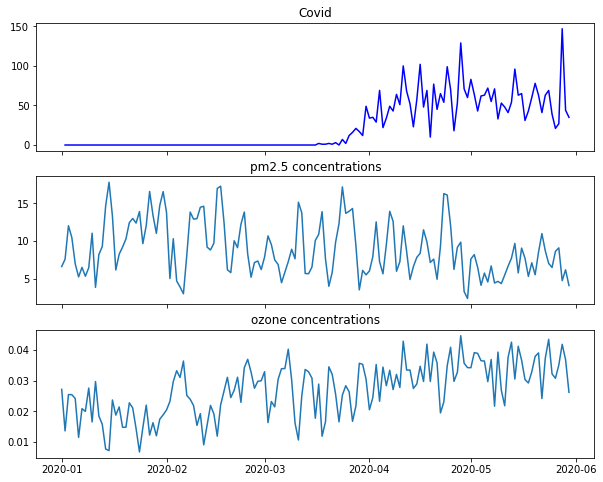

In [320]:

#covdf = load_and_augment_fips(tfip)
covdf = load_and_augment_fips_2(lake_covid,tfip)
covdf2 = covdf.loc[:'2020-05-30']

fig, axs = plt.subplots(3,1,figsize =(10,8), sharex=True)
pm20_vals =pm20df[pm20df['fips'] == tfip]["Arithmetic Mean"].loc[:'2020-05-30']
ozone20_vals =ozone20df[ozone20df['fips'] == tfip]["Arithmetic Mean"].loc[:'2020-05-30']
#covid_title_text = "{} daily cases".format(get_county_from_fips(tfip))

#axs[0].set_title(covid_title_text)
axs[0].set_title('Covid')
axs[0].plot(covdf2["daily_new_cases"],'b',label="daily cases")
#axs[0].annotate('Problem region',
            #xy=(pd.to_datetime('2020-01-30'), 3), xycoords='data',
            #xytext=(0.2, 0.5), textcoords='axes fraction',
            #arrowprops=dict(facecolor='black',shrink=0.05),
             #horizontalalignment='center', verticalalignment='top',fontsize = 15)
axs[1].plot(pm20_vals)
axs[1].set_title("pm2.5 concentrations")

axs[2].plot(ozone20_vals)
axs[2].set_title("ozone concentrations")

In [321]:
tkey = tfip 
target_key_pm = pm20_cref_keys.index(tkey)
target_key_oz = ozone20_cref_keys.index(tkey)

#tempdf = load_and_augment_fips(cref_keys[4])
tempdf = load_and_augment_fips_2(lake_covid,tfip)
tightdf = tempdf.loc['2020-05-20':'2021-03-01']
narrow_covid = tightdf.drop(["fips","latestTotalPopulation"], axis =1)

tpm20 = pm20df[pm20df['fips'] == pm20_cref_keys[target_key_pm]].copy()
toz20 = ozone20df[ozone20df['fips'] == ozone20_cref_keys[target_key_oz]].copy()

tpm20 = tpm20.loc['2020-05-20':'2021-03-01']
toz20 = toz20.loc['2020-05-20':'2021-03-01']

tight_correlation_pm20 = tpm20.join(tightdf,lsuffix="_L", rsuffix="_R")
tight_correlation_ozone20 = toz20.join(tightdf,lsuffix="_L", rsuffix="_R")

In [352]:
tight_correlation_pm20.corr()

,Arithmetic Mean,1st Max Value,AQI,daily_new_cases,daily_new_deaths,1wkroll,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,latestTotalPopulation,total_cases_per_100k,deaths_per_cases
Arithmetic Mean,1.000000,0.669922,0.953957,0.314042,0.204686,0.338746,0.330470,0.302165,NaN,0.330470,-0.192037
1st Max Value,0.669922,1.000000,0.685461,0.268947,0.077137,0.273298,0.212034,0.193739,NaN,0.212034,-0.138845
AQI,0.953957,0.685461,1.000000,0.322188,0.194469,0.337205,0.321885,0.301362,NaN,0.321885,-0.212684
daily_new_cases,0.314042,0.268947,0.322188,1.000000,0.338795,0.942640,0.758579,0.738067,NaN,0.758579,-0.746328
daily_new_deaths,0.204686,0.077137,0.194469,0.338795,1.000000,0.391296,0.407479,0.355583,NaN,0.407479,-0.258626
1wkroll,0.338746,0.273298,0.337205,0.942640,0.391296,1.000000,0.835835,0.804487,NaN,0.835835,-0.792765
JHU_ConfirmedCases.data,0.330470,0.212034,0.321885,0.758579,0.407479,0.835835,1.000000,0.982845,NaN,1.000000,-0.872872
JHU_ConfirmedDeaths.data,0.302165,0.193739,0.301362,0.738067,0.355583,0.804487,0.982845,1.000000,NaN,0.982845,-0.921169
latestTotalPopulation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_cases_per_100k,0.330470,0.212034,0.321885,0.758579,0.407479,0.835835,1.000000,0.982845,NaN,1.000000,-0.872872


In [353]:
tight_correlation_ozone20.corr()

,Arithmetic Mean,1st Max Value,AQI,daily_new_cases,daily_new_deaths,1wkroll,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,latestTotalPopulation,total_cases_per_100k,deaths_per_cases
Arithmetic Mean,1.000000,0.926698,0.853139,-0.483410,-0.164303,-0.546693,-0.621803,-0.648959,NaN,-0.621803,0.708590
1st Max Value,0.926698,1.000000,0.938099,-0.534056,-0.232734,-0.587840,-0.658827,-0.675858,NaN,-0.658827,0.725688
AQI,0.853139,0.938099,1.000000,-0.438994,-0.176315,-0.477806,-0.534961,-0.553296,NaN,-0.534961,0.631178
daily_new_cases,-0.483410,-0.534056,-0.438994,1.000000,0.338795,0.942640,0.758579,0.738067,NaN,0.758579,-0.746328
daily_new_deaths,-0.164303,-0.232734,-0.176315,0.338795,1.000000,0.391296,0.407479,0.355583,NaN,0.407479,-0.258626
1wkroll,-0.546693,-0.587840,-0.477806,0.942640,0.391296,1.000000,0.835835,0.804487,NaN,0.835835,-0.792765
JHU_ConfirmedCases.data,-0.621803,-0.658827,-0.534961,0.758579,0.407479,0.835835,1.000000,0.982845,NaN,1.000000,-0.872872
JHU_ConfirmedDeaths.data,-0.648959,-0.675858,-0.553296,0.738067,0.355583,0.804487,0.982845,1.000000,NaN,0.982845,-0.921169
latestTotalPopulation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_cases_per_100k,-0.621803,-0.658827,-0.534961,0.758579,0.407479,0.835835,1.000000,0.982845,NaN,1.000000,-0.872872


In [324]:
tight_correlation_pm20.corr(method='spearman')

,Arithmetic Mean,1st Max Value,AQI,daily_new_cases,daily_new_deaths,1wkroll,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,latestTotalPopulation,total_cases_per_100k,deaths_per_cases
Arithmetic Mean,1.000000,0.767747,0.956580,0.235787,0.132662,0.208276,0.178203,0.178527,NaN,0.178203,-0.167077
1st Max Value,0.767747,1.000000,0.749621,0.267762,0.121651,0.239261,0.219306,0.219491,NaN,0.219306,-0.214147
AQI,0.956580,0.749621,1.000000,0.245699,0.123125,0.232758,0.211554,0.211743,NaN,0.211554,-0.200058
daily_new_cases,0.235787,0.267762,0.245699,1.000000,0.312263,0.883605,0.787412,0.787601,NaN,0.787412,-0.798620
daily_new_deaths,0.132662,0.121651,0.123125,0.312263,1.000000,0.313128,0.287540,0.291230,NaN,0.287540,-0.288484
1wkroll,0.208276,0.239261,0.232758,0.883605,0.313128,1.000000,0.825136,0.824997,NaN,0.825136,-0.843915
JHU_ConfirmedCases.data,0.178203,0.219306,0.211554,0.787412,0.287540,0.825136,1.000000,0.999956,NaN,1.000000,-0.992049
JHU_ConfirmedDeaths.data,0.178527,0.219491,0.211743,0.787601,0.291230,0.824997,0.999956,1.000000,NaN,0.999956,-0.991915
latestTotalPopulation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_cases_per_100k,0.178203,0.219306,0.211554,0.787412,0.287540,0.825136,1.000000,0.999956,NaN,1.000000,-0.992049


In [325]:
tight_correlation_ozone20.corr(method='spearman')

,Arithmetic Mean,1st Max Value,AQI,daily_new_cases,daily_new_deaths,1wkroll,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,latestTotalPopulation,total_cases_per_100k,deaths_per_cases
Arithmetic Mean,1.000000,0.923516,0.923512,-0.502514,-0.209077,-0.589572,-0.723067,-0.722187,NaN,-0.723067,0.728139
1st Max Value,0.923516,1.000000,0.999910,-0.571767,-0.291813,-0.628976,-0.759955,-0.759366,NaN,-0.759955,0.766549
AQI,0.923512,0.999910,1.000000,-0.571711,-0.291062,-0.628422,-0.759505,-0.758903,NaN,-0.759505,0.766164
daily_new_cases,-0.502514,-0.571767,-0.571711,1.000000,0.312263,0.883605,0.787412,0.787601,NaN,0.787412,-0.798620
daily_new_deaths,-0.209077,-0.291813,-0.291062,0.312263,1.000000,0.313128,0.287540,0.291230,NaN,0.287540,-0.288484
1wkroll,-0.589572,-0.628976,-0.628422,0.883605,0.313128,1.000000,0.825136,0.824997,NaN,0.825136,-0.843915
JHU_ConfirmedCases.data,-0.723067,-0.759955,-0.759505,0.787412,0.287540,0.825136,1.000000,0.999956,NaN,1.000000,-0.992049
JHU_ConfirmedDeaths.data,-0.722187,-0.759366,-0.758903,0.787601,0.291230,0.824997,0.999956,1.000000,NaN,0.999956,-0.991915
latestTotalPopulation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_cases_per_100k,-0.723067,-0.759955,-0.759505,0.787412,0.287540,0.825136,1.000000,0.999956,NaN,1.000000,-0.992049


Text(0.5, 1.0, 'Ozone Concentrations')

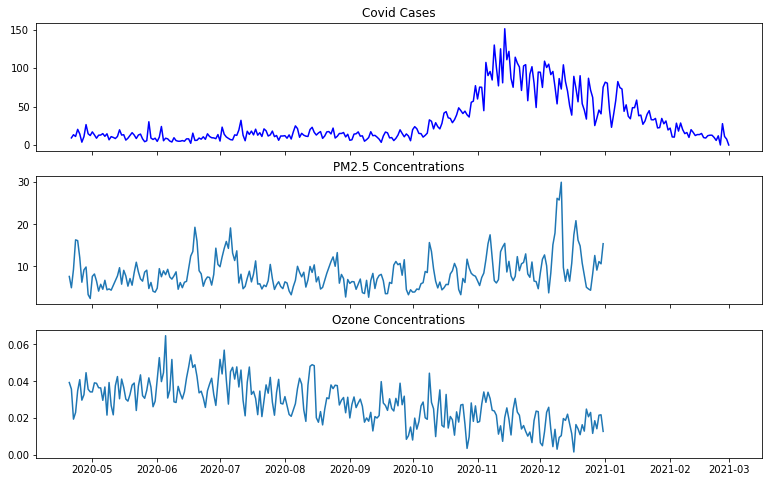

In [326]:

covdf2 = tempdf.loc['2020-04-20':'2021-03-01']
fig, axs = plt.subplots(3,1,figsize =(13,8), sharex=True)

pm20_vals =pm20df[pm20df['fips'] == tfip]["Arithmetic Mean"].loc['2020-04-20':'2021-03-01']
ozone20_vals =ozone20df[ozone20df['fips'] == tfip]["Arithmetic Mean"].loc['2020-04-20':'2021-03-01']
#covid_title_text = "{} daily cases".format(get_county_from_fips(tfip))

#axs[0].set_title(covid_title_text)
axs[0].set_title('Covid Cases')
axs[0].plot(covdf2["total_cases_per_100k"].diff(),'b',label="daily cases")
# axs[0].annotate('Problem region',
#             xy=(pd.to_datetime('2020-01-30'), 3), xycoords='data',
#             xytext=(0.2, 0.5), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black',shrink=0.05),
#              horizontalalignment='center', verticalalignment='top',fontsize = 15)
axs[1].plot(pm20_vals)
axs[1].set_title("PM2.5 Concentrations")

axs[2].plot(ozone20_vals)
axs[2].set_title("Ozone Concentrations")

In [274]:
def plot_corr_pollutants(tfip,covid_df,vals_1,vals_2):
    #tfip = "06001"
    #covdf = load_and_augment_fips(tfip)
    #covdf = load_and_augment_fips_2(covid_df,tfip)
    #covdf2 = covdf.loc[:'2020-05-30']

    fig, axs = plt.subplots(3,1,figsize =(10,8), sharex=True)
    pm20_vals =pm20df[pm20df['fips'] == tfip]["Arithmetic Mean"].loc[:'2020-05-30']
    ozone20_vals =ozone20df[ozone20df['fips'] == tfip]["Arithmetic Mean"].loc[:'2020-05-30']
    #covid_title_text = "{} daily cases".format(get_county_from_fips(tfip))

    #axs[0].set_title(covid_title_text)
    axs[0].set_title('Covid Daily Cases')
    axs[0].plot(covid_df["daily_new_cases"],'b',label="daily cases")
    #axs[0].annotate('Problem region',
            #xy=(pd.to_datetime('2020-01-30'), 3), xycoords='data',
            #xytext=(0.2, 0.5), textcoords='axes fraction',
            #arrowprops=dict(facecolor='black',shrink=0.05),
             #horizontalalignment='center', verticalalignment='top',fontsize = 15)
    axs[1].plot(vals_1)
    axs[1].set_title("pm2.5 concentrations")

    axs[2].plot(vals_2)
    axs[2].set_title("ozone concentrations")

In [276]:
#plot_corr_pollutants(tfip,lake_covid,pm20_vals,ozone20_vals)

Text(0.5, 1.0, 'PM2.5 Concentrations')

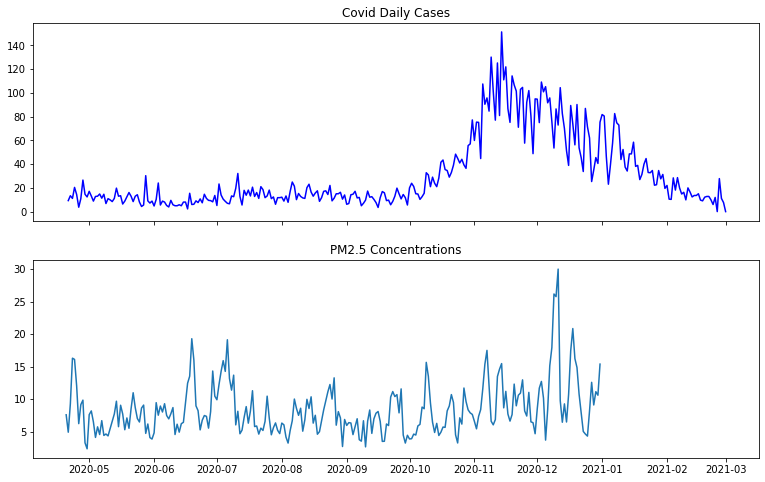

In [327]:
covdf2 = tempdf.loc['2020-04-20':'2021-03-01']
fig, axs = plt.subplots(2,1,figsize =(13,8), sharex=True)

pm20_vals =pm20df[pm20df['fips'] == tfip]["Arithmetic Mean"].loc['2020-04-20':'2021-03-01']
#covid_title_text = "{} daily cases".format(get_county_from_fips(tfip))

#axs[0].set_title(covid_title_text)
axs[0].set_title('Covid Daily Cases')
axs[0].plot(covdf2["total_cases_per_100k"].diff(),'b',label="daily cases")
# axs[0].annotate('Problem region',
#             xy=(pd.to_datetime('2020-01-30'), 3), xycoords='data',
#             xytext=(0.2, 0.5), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black',shrink=0.05),
#              horizontalalignment='center', verticalalignment='top',fontsize = 15)
axs[1].plot(pm20_vals)
axs[1].set_title("PM2.5 Concentrations")

Text(0.5, 1.0, 'Ozone Concentrations')

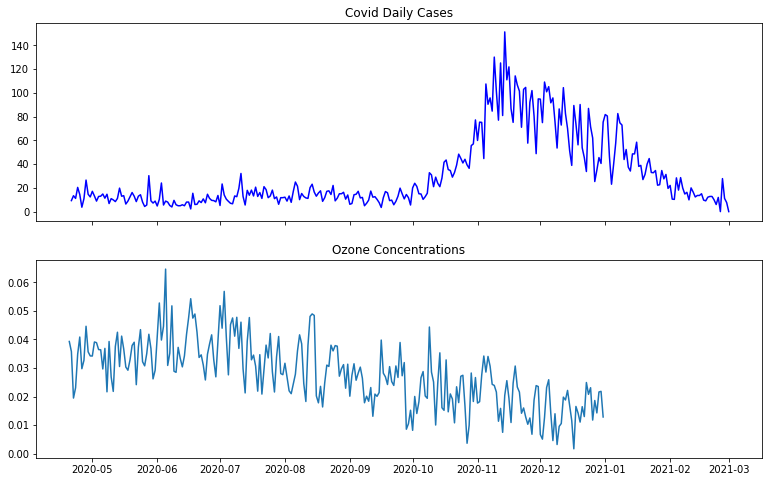

In [328]:
covdf2 = tempdf.loc['2020-04-20':'2021-03-01']
fig, axs = plt.subplots(2,1,figsize =(13,8), sharex=True)

ozone20_vals =ozone20df[ozone20df['fips'] == tfip]["Arithmetic Mean"].loc['2020-04-20':'2021-03-01']
#covid_title_text = "{} daily cases".format(get_county_from_fips(tfip))

#axs[0].set_title(covid_title_text)
axs[0].set_title('Covid Daily Cases')
axs[0].plot(covdf2["total_cases_per_100k"].diff(),'b',label="daily cases")
# axs[0].annotate('Problem region',
#             xy=(pd.to_datetime('2020-01-30'), 3), xycoords='data',
#             xytext=(0.2, 0.5), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black',shrink=0.05),
#              horizontalalignment='center', verticalalignment='top',fontsize = 15)
axs[1].plot(ozone20_vals)
axs[1].set_title("Ozone Concentrations")

# ----------- another look

In [329]:
#give fips, get county

def get_county_name(df,fips_code):
    countyName = df[df['fips'] == fips_code]
    countyName = pd.DataFrame(countyName, columns = ['County Name','fips'])
    return pd.unique(countyName['County Name'])


#give county, get fips
def get_fips(df,county_name):
    fips_df = df[df['County Name'] == county_name]
    fips_df = pd.DataFrame(fips_df, columns = ['fips','County Name'])
    return pd.unique(fips_df['fips'])

def condense_df(df):
    df = pd.DataFrame(df, columns = ['fips','County Name','Date Local','Arithmetic Mean'])
    return df

def collect_single_fips(df,fips):
    df_result = df[df['fips'] == fips]
    return df_result

def condense_single_fips(df,fips):
    df = pd.DataFrame(df, columns = ['fips','County Name','Date Local','Arithmetic Mean'])
    df_result = df[df['fips'] == fips]
    return df_result

def pull_from_repo():
    return df

def acf_plot(tfip,df):
    df_vals =df[df['fips'] == tfip]["Arithmetic Mean"].loc[:'2020-05-30']
    plot_acf(df_vals)
    plt.show()

## comparing mortality rate and pollutant increase 

In [330]:
denver_cvd = load_and_augment_fips_2(denver_covid,'08031')
denver_cvd.head(2)

,fips,daily_new_cases,daily_new_deaths,1wkroll,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,latestTotalPopulation,total_cases_per_100k,deaths_per_cases
dates,,,,,,,,,
2020-01-01,08031,NaN,NaN,NaN,0.0,0.0,727211.0,0.0,0.0
2020-01-02,08031,0.0,0.0,NaN,0.0,0.0,727211.0,0.0,0.0


In [331]:
#mortality rate ratio (mrr) attempt, = deaths/population

denver_test = denver_cvd
denver_test['MRR'] = denver_test['JHU_ConfirmedDeaths.data']/denver_test['latestTotalPopulation']*100

In [332]:
denver_test['MRR'].unique

<bound method Series.unique of dates
2020-01-01    0.000000
2020-01-02    0.000000
2020-01-03    0.000000
2020-01-04    0.000000
2020-01-05    0.000000
                ...   
2021-10-11    0.119635
2021-10-12    0.119635
2021-10-13    0.119635
2021-10-14    0.119635
2021-10-15    0.119635
Name: MRR, Length: 654, dtype: float64>

In [333]:
#create daily average for mrr and compare to daily average of arithmetic mean

Text(0.5, 1.0, 'ozone')

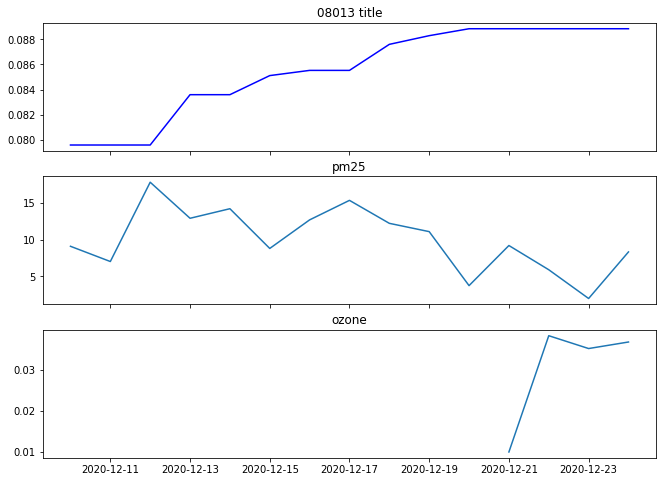

In [334]:
    tfip = '08013'
    center_date = pd.Timestamp('2020-12-17')
    
    fig, axs = plt.subplots(3,1,figsize =(11,8), sharex=True)
    pm20_df_vals = pm20df[pm20df['fips'] == tfip].loc[center_date - offset:center_date+offset]["Arithmetic Mean"]
    oz20_df_vals = ozone20df[ozone20df['fips'] == tfip].loc[center_date - offset:center_date+offset]["Arithmetic Mean"]
    
    covdf22 = denver_test['MRR']
    cov_interval = covdf22.loc[center_date - offset:center_date+offset]
    
    title_text = "{} title".format(tfip)
    axs[0].set_title(title_text)
    axs[0].plot(cov_interval,'b')
    axs[1].plot(pm20_df_vals)
    axs[1].set_title("pm25")
    axs[2].plot(oz20_df_vals)
    axs[2].set_title("ozone")

### ACF
Autocorrelation estimates the influence of all past observed values on the currently observed value. This differs from partial autocorrelation in which only a single past observed value is measured for influence on the currently observed value.

For autocorrelation plot the shaded region is the confidence interval with a default value of α = 0.05. Anything within this range represents a value that has no significant correlation with the most recent value for the price.

https://www.alpharithms.com/autocorrelation-time-series-python-432909/#:~:text=%20Autocorrelation%20%28ACF%29%20is%20a%20calculated%20value%20used,insights%20about%20observed%20values%20in%20time%20series%20data.

In [335]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

In [336]:
#data = data[['Date', 'Observations']].set_index(['Date'])
#Calculate the ACF (via statsmodel)
#plot_acf(data)
#Show the data as a plot (via matplotlib)
#plt.show()

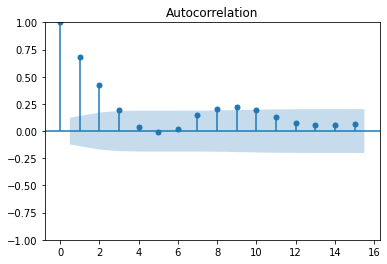

In [337]:
#test = test[['Date', 'Observations']].set_index(['Date'])
plot_acf(pm20_vals, lags=15)
plt.show()

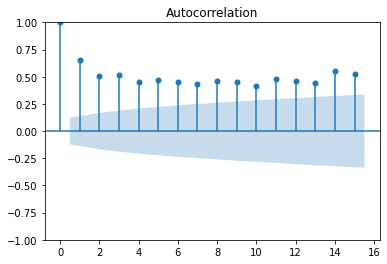

In [338]:
plot_acf(ozone20_vals, lags=15)
plt.show()

In [339]:
#plot_acf(lead20_vals, lags=15)
#plt.show()

In [340]:
#tfip = target_fips
#center_date = ex_dict[tfip]
center_date = pd.Timestamp('2020-12-05')
#covdf2 = load_and_augment_fips_2(denver_covid,tfip)
#cov_interval = covdf2.loc[center_date - offset:center_date+offset]

pm20_values = pm20df.loc[center_date - offset:center_date+offset]["Arithmetic Mean"]
ozone20_values = ozone20df.loc[center_date - offset:center_date+offset]["Arithmetic Mean"]
lead20_values = lead20df.loc[center_date - offset:center_date+offset]["Arithmetic Mean"]

In [341]:
maptest_pm20 = flat_daily_avg_pm20.drop(columns=['1st Max Value','AQI'],axis=1)
maptest_oz20 = flat_daily_avg_ozone20.drop(columns=['1st Max Value','AQI'],axis=1)

In [342]:
#map visualization of pollutants
#contry heat map

In [343]:
## high and low concentrations across all counties
print('pm')
print(max(pm20df["Arithmetic Mean"]))
print(pm20df["Arithmetic Mean"].mean())
print(min(pm20df["Arithmetic Mean"]))

print('\n','ozone')
print(max(ozone20df["Arithmetic Mean"]))
print(ozone20df["Arithmetic Mean"].mean())
print(min(ozone20df["Arithmetic Mean"]))


print('\n','lead')
print(max(lead20df["Arithmetic Mean"]))
print(lead20df["Arithmetic Mean"].mean())
print(min(lead20df["Arithmetic Mean"]))

pm
692.3259469999999
7.781185312956149
-4.5208335

 ozone
0.105176
0.03006179008579186
-0.0033

 lead
0.916
0.020707880643627982
0.0


In [344]:
## condensed high and lows
pm20_df = pm20df.drop(columns=['1st Max Value','AQI'],axis=1).loc['2020-04-20':'2021-03-01']
ozone20_df = ozone20df.drop(columns=['1st Max Value','AQI'],axis=1).loc['2020-04-20':'2021-03-01']
lead20_df = lead20df.drop(columns=['1st Max Value','AQI'],axis=1).loc['2020-04-20':'2021-03-01']

In [345]:
pm20_max = max(pm20_df["Arithmetic Mean"])
pm20_mean = pm20_df["Arithmetic Mean"].mean()
pm20_min = min(pm20_df["Arithmetic Mean"])

ozone20_max = max(ozone20_df["Arithmetic Mean"])
ozone20_mean = ozone20_df["Arithmetic Mean"].mean()
ozone20_min = min(ozone20_df["Arithmetic Mean"])



lead20_max = max(lead20_df["Arithmetic Mean"])
lead20_mean = lead20_df["Arithmetic Mean"].mean()
lead20_min = min(lead20_df["Arithmetic Mean"])

In [346]:
pm20_df.loc[pm20_df['Arithmetic Mean']==pm20_max]

,fips,Arithmetic Mean
Date Local,,
2020-09-14,06051,692.325947


In [347]:
ozone20_df.loc[ozone20_df['Arithmetic Mean']==ozone20_max]

,fips,Arithmetic Mean
Date Local,,
2020-08-20,06057,0.105176


In [348]:
lead20_df.loc[lead20_df['Arithmetic Mean']==lead20_max]

,fips,Arithmetic Mean
Date Local,,
2020-08-21,29093,0.916


In [349]:
print('pm max: ', get_county_name(pm20,'06051'))
pm20_centerdate = pd.Timestamp('2020-09-14')
print('ozone max: ', get_county_name(ozone20,'06057'))
ozone20_centerdate = pd.Timestamp('2020-08-20')
print('lead max: ', get_county_name(lead20,'29093'))
lead20_centerdate = pd.Timestamp('2020-08-21')

pm max:  ['Mono']
ozone max:  ['Nevada']
lead max:  ['Iron']


In [357]:
#mono #pm max arith mean county
#nevada #ozone max arith mean county
#iron #iron max arith mean county

In [359]:
mono = pd.read_pickle('Monona_Iowa_UnitedStates.pkl')
nevada = pd.read_pickle('Nevada_California_UnitedStates.pkl')
iron = pd.read_pickle('Iron_Missouri_UnitedStates.pkl')

mono_covid = load_and_augment_fips_2(mono,'06051')
nevada_covid = load_and_augment_fips_2(nevada,'06057')
iron_covid = load_and_augment_fips_2(iron,'29093')

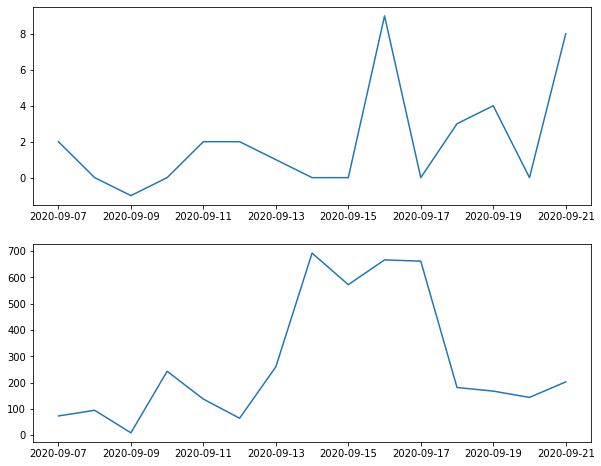

In [360]:
fig, axs = plt.subplots(2,1,figsize =(10,8) )
cov_interval = mono_covid.loc[pm20_centerdate- offset:pm20_centerdate+offset]
axs[0].plot(cov_interval['daily_new_cases'])

pm20_mono = pm20df[pm20df['fips'] == '06051'].loc[pm20_centerdate - offset:pm20_centerdate+offset]["Arithmetic Mean"]
axs[1].plot(pm20_mono)

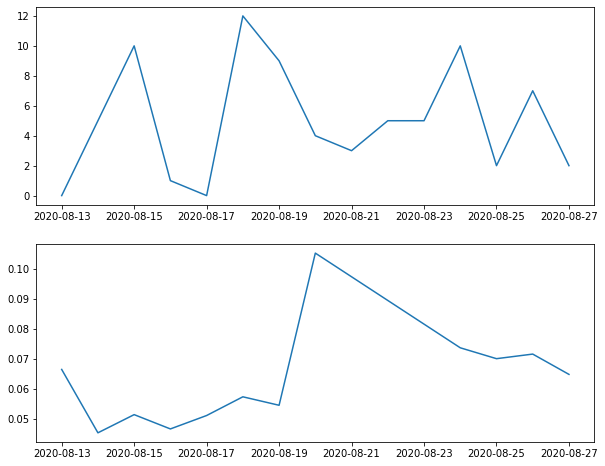

In [363]:
fig, axs = plt.subplots(2,1,figsize =(10,8) )
cov_interval = nevada_covid.loc[ozone20_centerdate- offset:ozone20_centerdate+offset]
axs[0].plot(cov_interval['daily_new_cases'])

ozone20_nevada = ozone20df[ozone20df['fips'] == '06057'].loc[ozone20_centerdate - offset:ozone20_centerdate+offset]["Arithmetic Mean"]
axs[1].plot(ozone20_nevada)

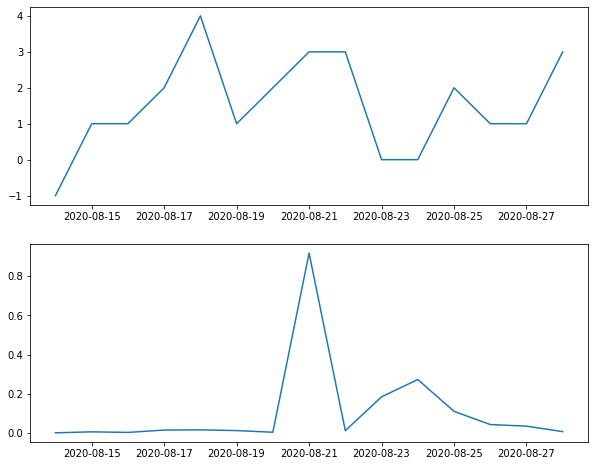

In [364]:
fig, axs = plt.subplots(2,1,figsize =(10,8) )
cov_interval = iron_covid.loc[lead20_centerdate- offset:lead20_centerdate+offset]
axs[0].plot(cov_interval['daily_new_cases'])

lead20_iron = lead20df[lead20df['fips'] == '29093'].loc[lead20_centerdate - offset:lead20_centerdate+offset]["Arithmetic Mean"]
axs[1].plot(lead20_iron)

In [365]:
## non-stationary time series detrends / correlations